# Projekt Modelu wykrywającego anomalie w sygnałach EKG
---
Link do datasetu: *https://www.kaggle.com/datasets/shayanfazeli/heartbeat*

### Content

> #### Arrhythmia Dataset
>* Number of Samples: 109446
>* Number of Categories: 5
>* Sampling Frequency: 125Hz
>* Data Source: Physionet's MIT-BIH Arrhythmia Dataset
>* Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

> #### The PTB Diagnostic ECG Database
>* Number of Samples: 14552
>* Number of Categories: 2
>* Sampling Frequency: 125Hz
>* Data Source: Physionet's PTB Diagnostic Database

_All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188._

## Rodzaje anomali w sygnałach EKG
![](Images/ECG_anomalies.jpeg)

## Pobieranie danych z Kaggle.com

In [12]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shayanfazeli/heartbeat")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\julit\.cache\kagglehub\datasets\shayanfazeli\heartbeat\versions\1


In [13]:
import os

# Wyświetl zawartość folderu
dataset_dir = path
print(os.listdir(dataset_dir))

['mitbih_test.csv', 'mitbih_train.csv', 'ptbdb_abnormal.csv', 'ptbdb_normal.csv']


## Wyznaczenie zbioru testowego

In [18]:
import pandas as pd

# Wczytaj dane treningowe
train_data = pd.read_csv(os.path.join(path, "mitbih_test.csv"))
print(train_data.head())

   1.000000000000000000e+00  7.582644820213317871e-01  \
0                  0.908425                  0.783883   
1                  0.730088                  0.212389   
2                  1.000000                  0.910417   
3                  0.570470                  0.399329   
4                  1.000000                  0.923664   

   1.115702465176582336e-01  0.000000000000000000e+00  \
0                  0.531136                  0.362637   
1                  0.000000                  0.119469   
2                  0.681250                  0.472917   
3                  0.238255                  0.147651   
4                  0.656489                  0.195929   

   8.057851344347000122e-02  7.851240038871765137e-02  \
0                  0.366300                  0.344322   
1                  0.101770                  0.101770   
2                  0.229167                  0.068750   
3                  0.000000                  0.003356   
4                  0.111959  

In [19]:
print(train_data.info())
print(train_data.iloc[:, -1].value_counts())  # Rozkład klas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21891 entries, 0 to 21890
Columns: 188 entries, 1.000000000000000000e+00 to 0.000000000000000000e+00.65
dtypes: float64(188)
memory usage: 31.4 MB
None
0.000000000000000000e+00.65
0.0    18117
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64


## Wyświetlanie sygnałów

Ostatnia kolumna w wierszu to etykieta wskazująca klasę.
> dla mitbih: 0 - normalny rytm, 1–4 - różne rodzaje arytmii<br>
> dla ptbdb: 0 - normalny rytm, 1 - arytmia

Wybieranie sygnału:
> signal = train_data.iloc[0, :-1]
>> 0 - wybiera wiersz<br>
>> :-1 - wszystkie kolumny z wyjątkiem ostatniej (kolumna klasy)


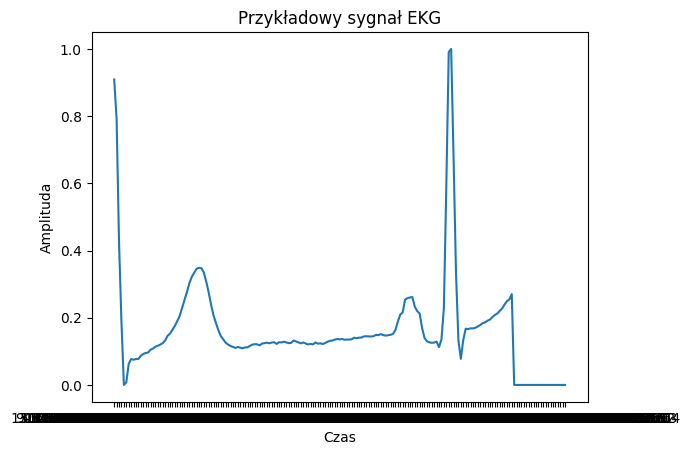

In [16]:
import matplotlib.pyplot as plt

# Przykład: Wizualizacja pierwszego sygnału EKG
signal = train_data.iloc[1, :-1]  # Pobierz sygnał (bez etykiety)
plt.plot(signal)
plt.title("Przykładowy sygnał EKG")
plt.xlabel("Czas")
plt.ylabel("Amplituda")
plt.show()

Wagi klas: {0: 1.0, 1: np.float64(4.896043771043771)}
Rozkład klas w zbiorze treningowym: [11633  2376]
Epoch 1/40


C:\Users\julit\Desktop\ECG-Signal-Anomaly-Detection-Model\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5138 - loss: 1.1167 - val_accuracy: 0.7342 - val_loss: 0.5802
Epoch 2/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7542 - loss: 0.9383 - val_accuracy: 0.7913 - val_loss: 0.4743
Epoch 3/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7750 - loss: 0.8676 - val_accuracy: 0.7802 - val_loss: 0.4605
Epoch 4/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7800 - loss: 0.8321 - val_accuracy: 0.8353 - val_loss: 0.4007
Epoch 5/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8147 - loss: 0.7504 - val_accuracy: 0.8204 - val_loss: 0.4197
Epoch 6/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8210 - loss: 0.7408 - val_accuracy: 0.8510 - val_loss: 0.3836
Epoch 7/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8368 - loss: 0.6981 - val_accuracy: 0.8550 - val_loss: 0.3704
Epoch 8/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8507 - loss: 0.6645 - val_accuracy: 0.8421 - val_

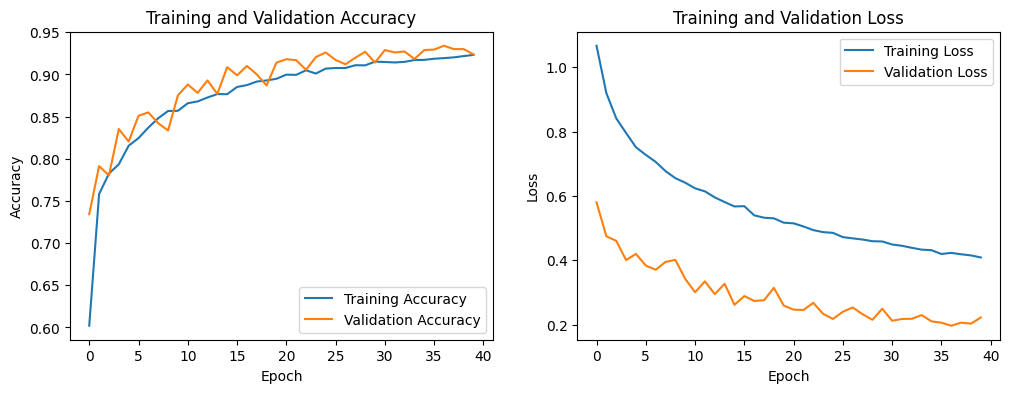

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os

# 1. Wczytanie danych
# Zakładam, że train_data jest już wczytane
# train_data = pd.read_csv(os.path.join(path, "mitbih_train.csv"))
# print(train_data.head())

# Przygotowanie danych
X = train_data.iloc[:, :-1].values  # Sygnały EKG
y = train_data.iloc[:, -1].values   # Etykiety
y = np.where(y == 0, 0, 1)  # 0 = dobry, reszta = niedobry

# Reshape do formatu (n_próbek, długość_sygnału, 1)
X = X.reshape(X.shape[0], X.shape[1], 1)

# 2. Normalizacja
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# 3. Podział danych
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 4. Obliczenie wag klas
# Waga dla klasy 1 (niedobry) = liczba próbek klasy 0 / liczba próbek klasy 1
class_weight = {0: 1.0, 1: sum(y_train == 0) / sum(y_train == 1)}
print("Wagi klas:", class_weight)
print("Rozkład klas w zbiorze treningowym:", np.bincount(y_train))

# 5. Budowa modelu CNN
model = Sequential([
    Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(X.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=16, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),  # Zwiększony dropout, aby zapobiec przeuczeniu
    Dense(1, activation='sigmoid')
])

# Kompilacja modelu
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# 6. Trenowanie modelu z wagami klas
history = model.fit(X_train, y_train, epochs=40, batch_size=32,
                    validation_data=(X_val, y_val), class_weight=class_weight, verbose=1)

# 7. Ocena modelu
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Dodatkowe metryki
y_pred = (model.predict(X_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
print("Macierz pomyłek:\n", cm)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)  # Czułość
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # Specyficzność
print(f"Precision: {precision:.4f}, Recall (Sensitivity): {recall:.4f}, Specificity: {specificity:.4f}")

# 8. Funkcja predykcji
def predict_ekg(signal, model, scaler):
    if signal.ndim == 1:
        signal = signal.reshape(1, -1, 1)
    signal = scaler.transform(signal.reshape(-1, signal.shape[-1])).reshape(signal.shape)
    prediction = model.predict(signal, verbose=0)
    return "Dobry" if prediction[0] < 0.5 else "Niedobry"

# Przykład predykcji
sample_signal = X_test[0:1]
result = predict_ekg(sample_signal, model, scaler)
print(f"Wynik dla próbki: {result}")

# 9. Wizualizacja wyników
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()